## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

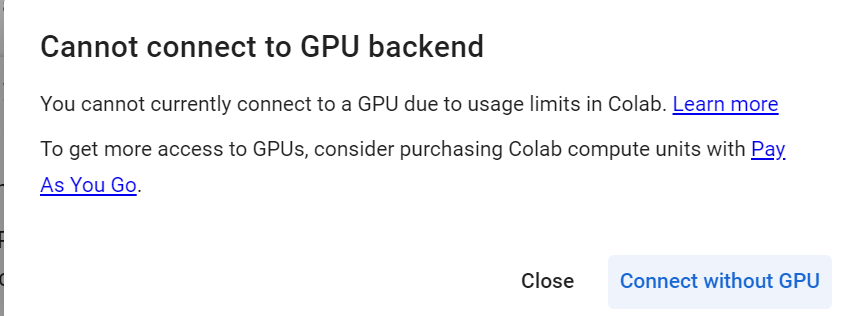

## **Installing and Importing Necessary Libraries**

In [ ]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.9 MB/s eta 0:00:00


In [ ]:
# installing the libraries for transformers
!pip install -U -q sentence-transformers transformers bitsandbytes accelerate sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 29.6 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Import modules from scikit-learn for machine learning tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report,make_scorer


# Deep Learning library
import torch

# to load transformer models
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline

# To encode the target variable
from sklearn.preprocessing import LabelEncoder

# To import Word2Vec
from gensim.models import Word2Vec

# Converting the Stanford GloVe model vector format to word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## **Loading the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading the dataset
news_data = pd.read_csv("/content/drive/MyDrive/AIML/NLP/stock_news.csv")

In [ ]:
# creating a copy of the dataset
data = news_data.copy()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


## **Data Overview**

In [ ]:
data.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [ ]:
data.shape

(349, 8)

In [ ]:
data.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


In [ ]:
data.duplicated().sum()

0

## **Exploratory Data Analysis**

In [ ]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
### Function to plot distributions

def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 3, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[0, 2].set_title("Distribution of target for target=" + str(target_uniq[2]))
    sns.histplot(
        data=data[data[target] == target_uniq[2]],
        x=predictor,
        kde=True,
        ax=axs[0, 2],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    axs[1, 2].remove()

    plt.tight_layout()
    plt.show()

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

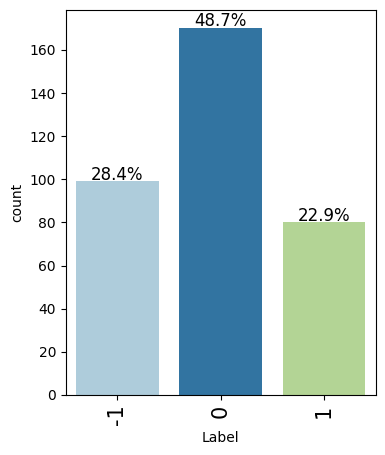

In [ ]:
labeled_barplot(data, "Label", perc=True)

- Dataset looks imbalanced towards neutral news articles. We might need to use balancing techniques like class_weights during model building

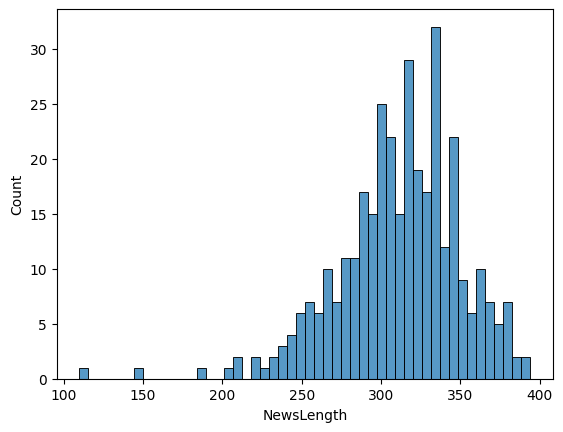

In [ ]:
data['NewsLength'] = data['News'].str.len()
sns.histplot(data, x='NewsLength', bins =50);

- Most of the news articles seem to be of good length to do sentiment analysis

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

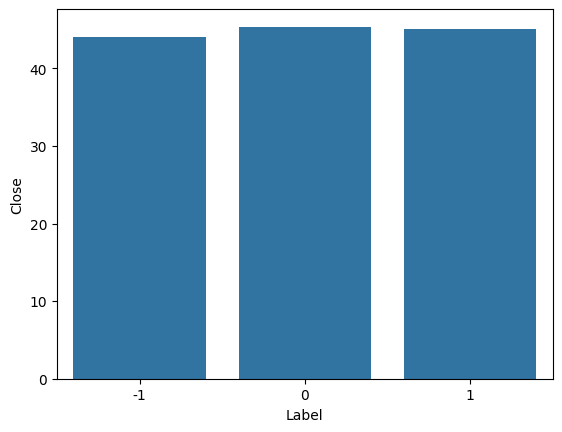

In [ ]:
sns.barplot(data, y='Close', x='Label', errorbar=('ci', False));

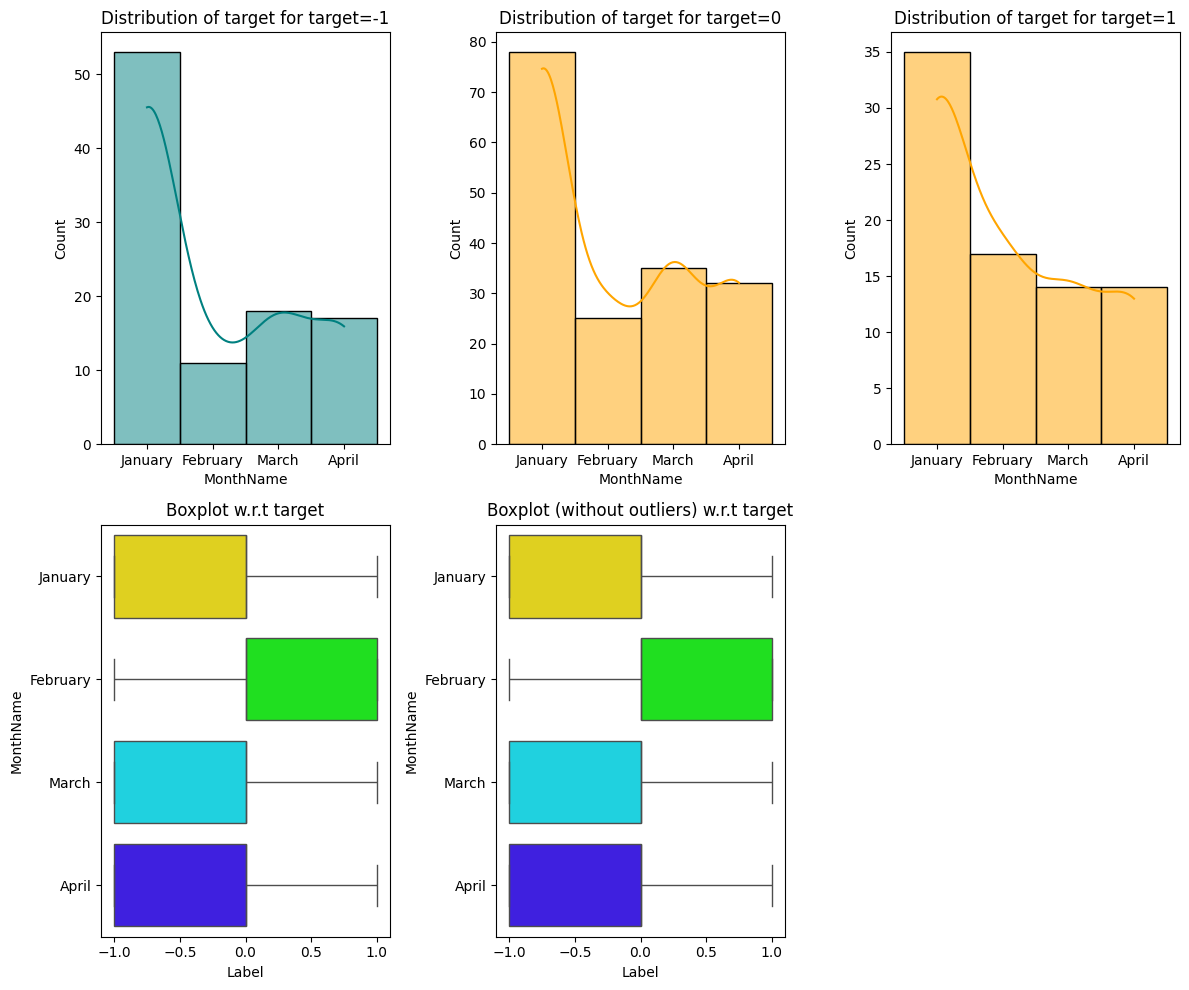

In [ ]:
data['DateFormatted'] = pd.to_datetime(data['Date'])
data['Year'] = data['DateFormatted'].dt.year
data['Month'] = data['DateFormatted'].dt.month
data['MonthName'] = pd.to_datetime(data['Month'], format='%m').dt.month_name()

distribution_plot_wrt_target(data,'MonthName','Label')


- It looks like February has a particularly positive sentiment articles

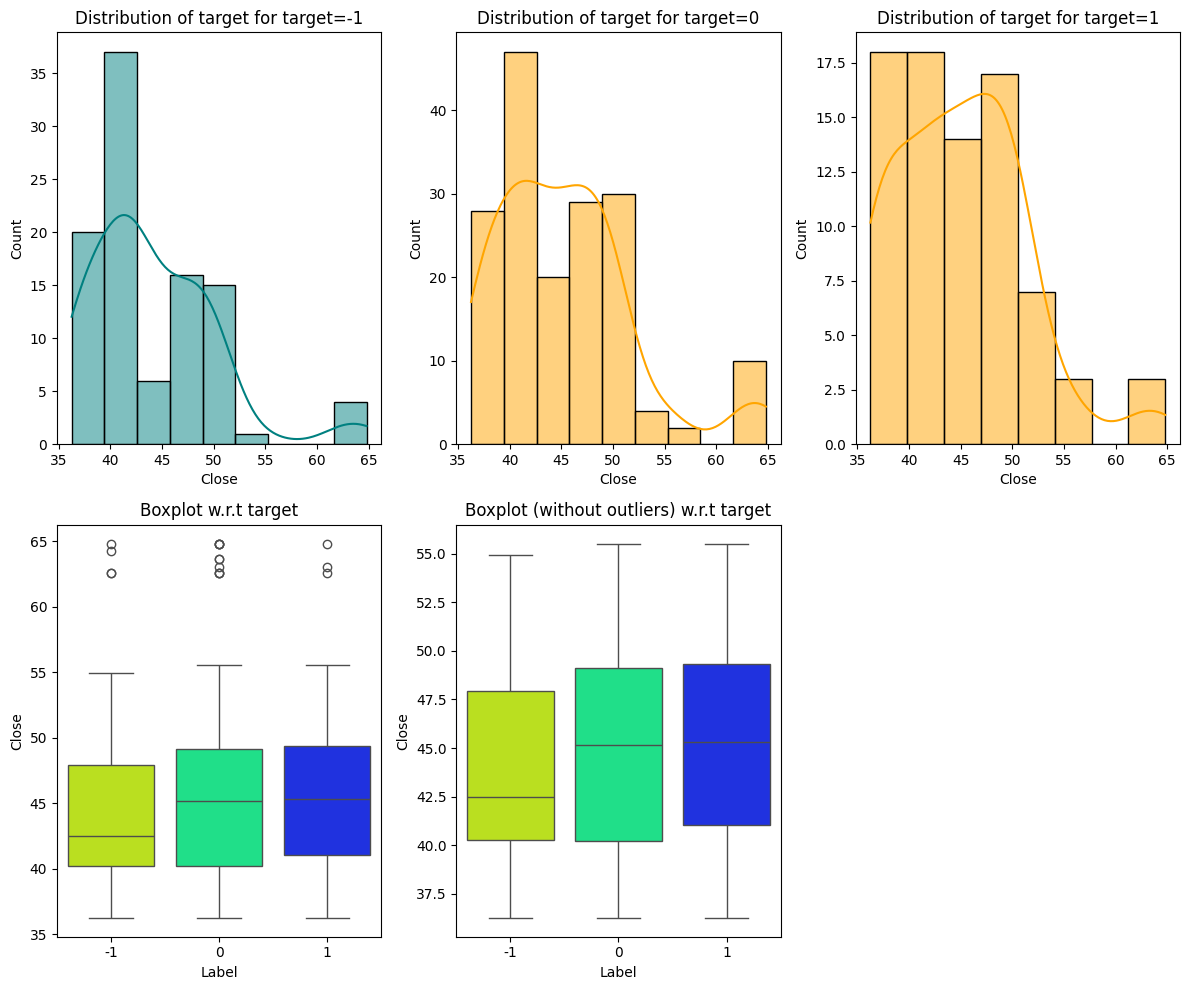

In [ ]:
distribution_plot_wrt_target(data,'Close','Label')

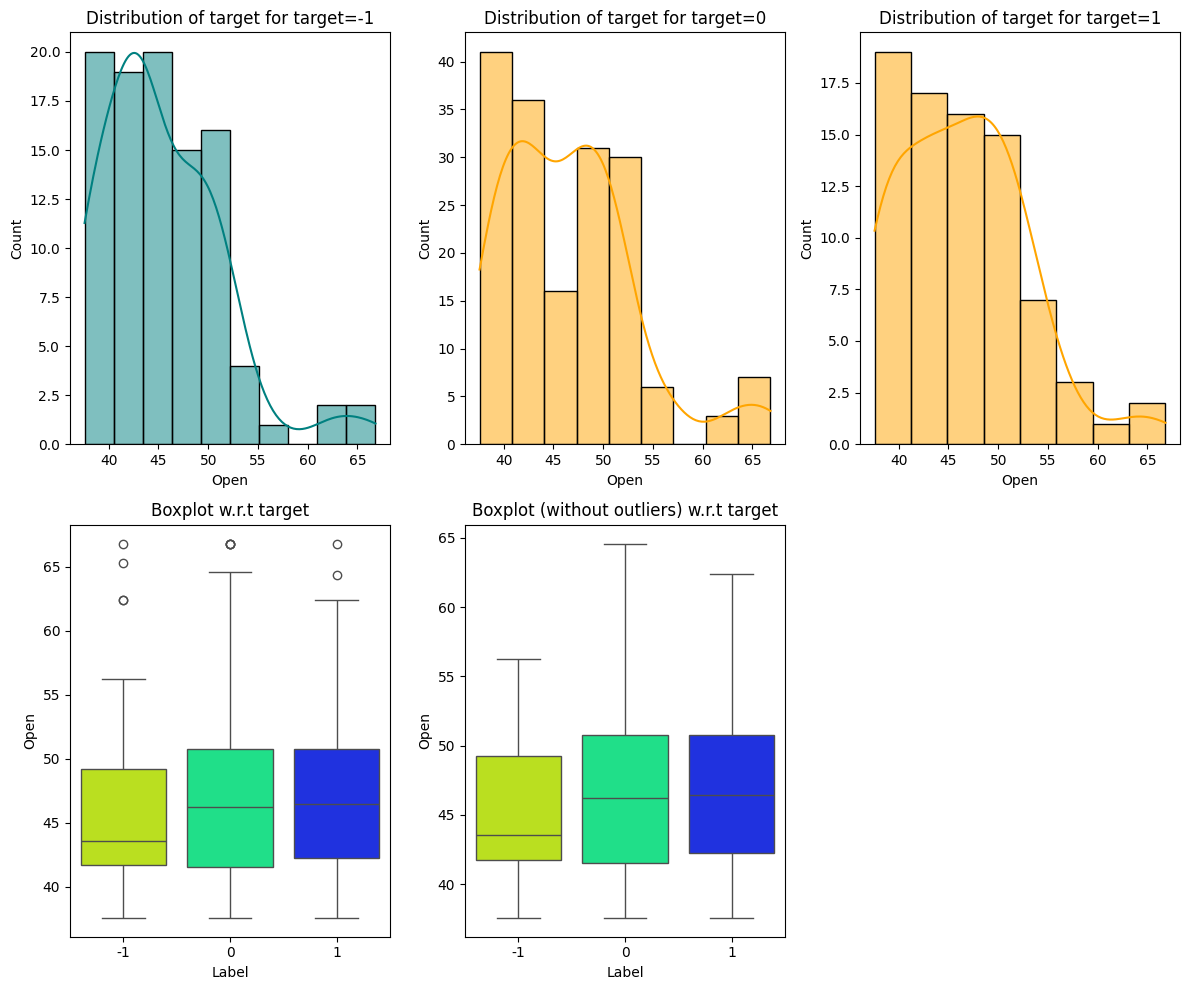

In [ ]:
distribution_plot_wrt_target(data,'Open','Label')

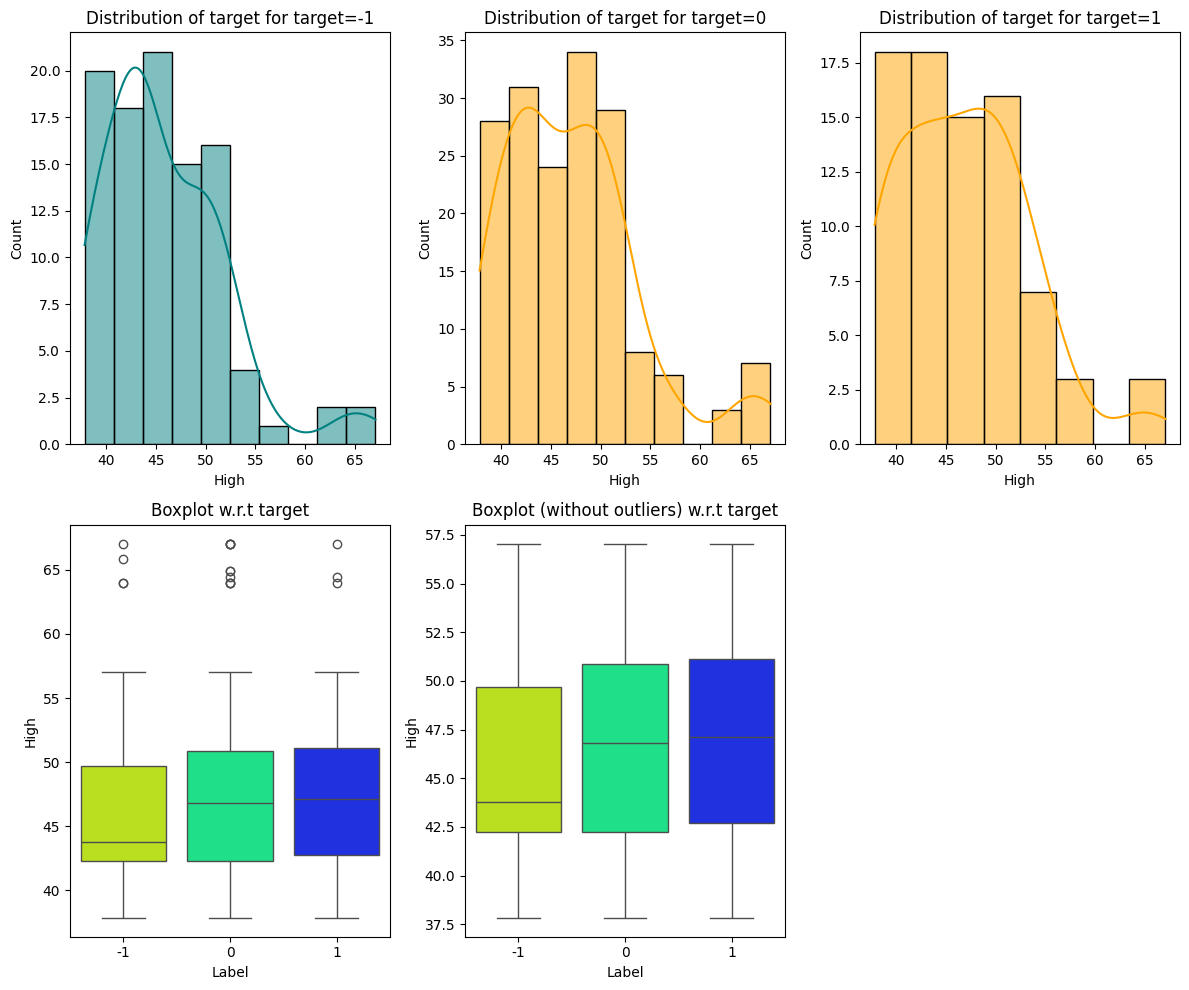

In [ ]:
distribution_plot_wrt_target(data,'High','Label')

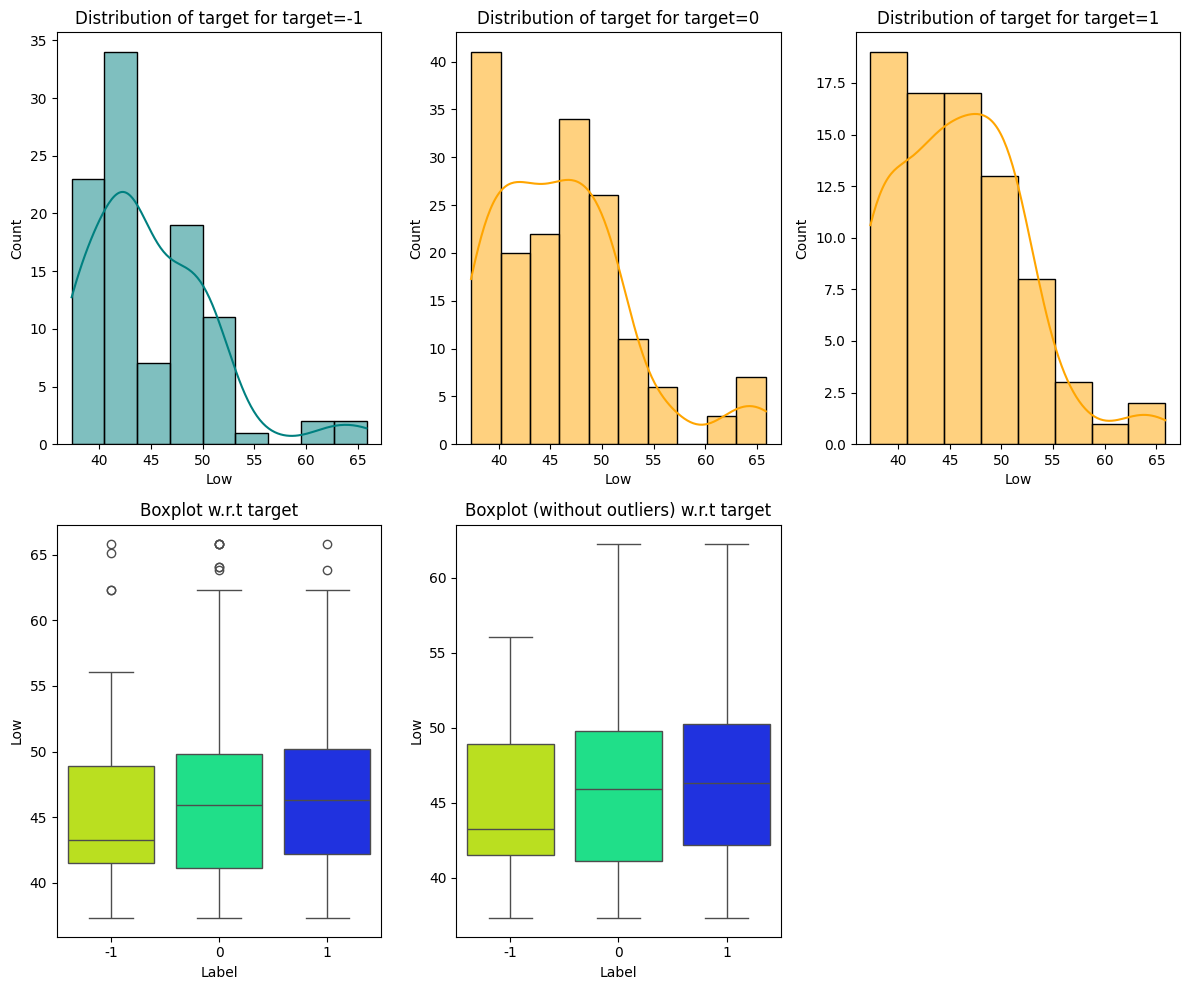

In [ ]:
distribution_plot_wrt_target(data,'Low','Label')

- The Label doesn't seem to make a difference in Close, Open, High or Low prices.

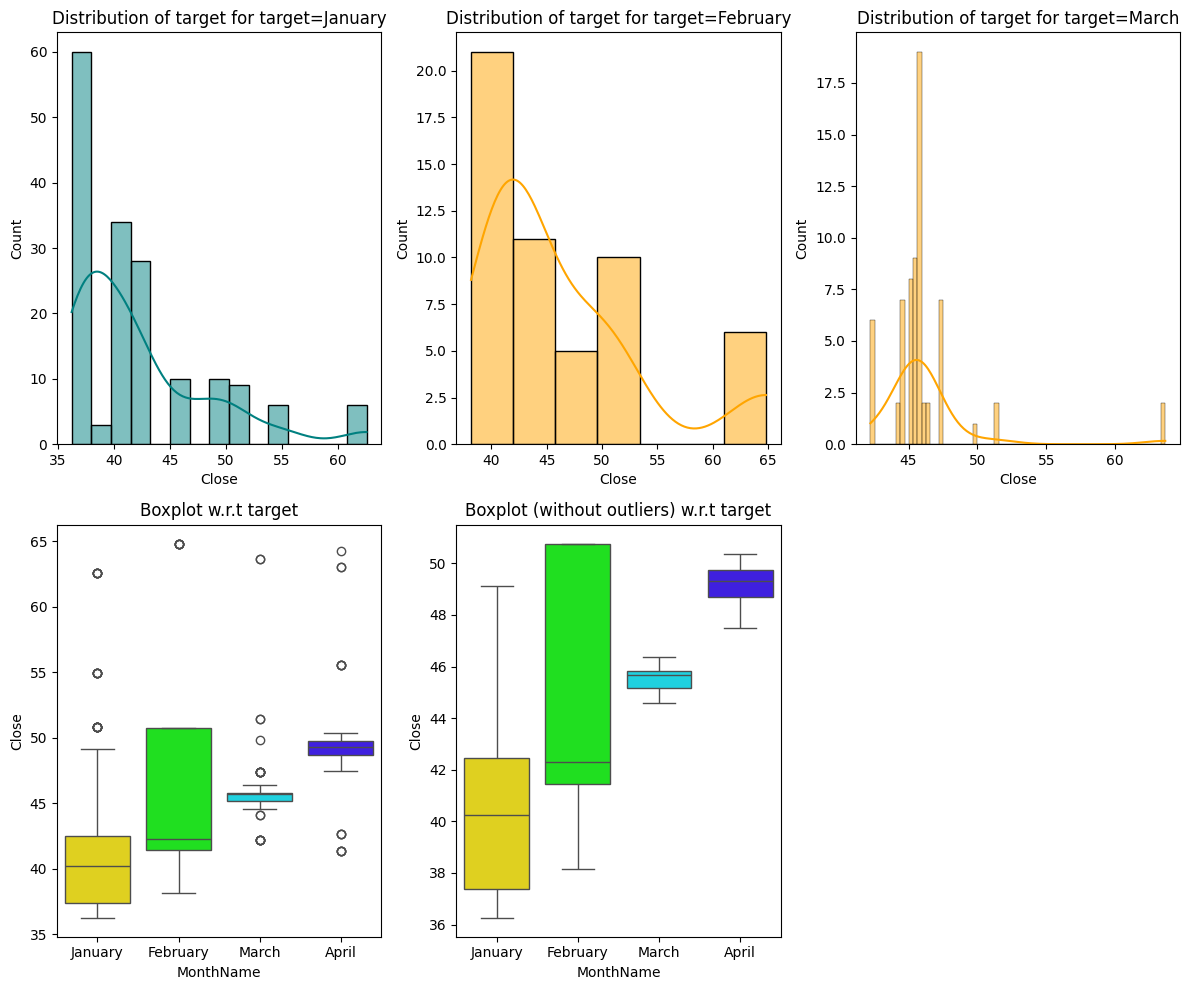

In [ ]:
distribution_plot_wrt_target(data,'Close','MonthName')

- January and February seems to be generally high on volume of news articles (not to confuse this with the "Volume" in the dataset).

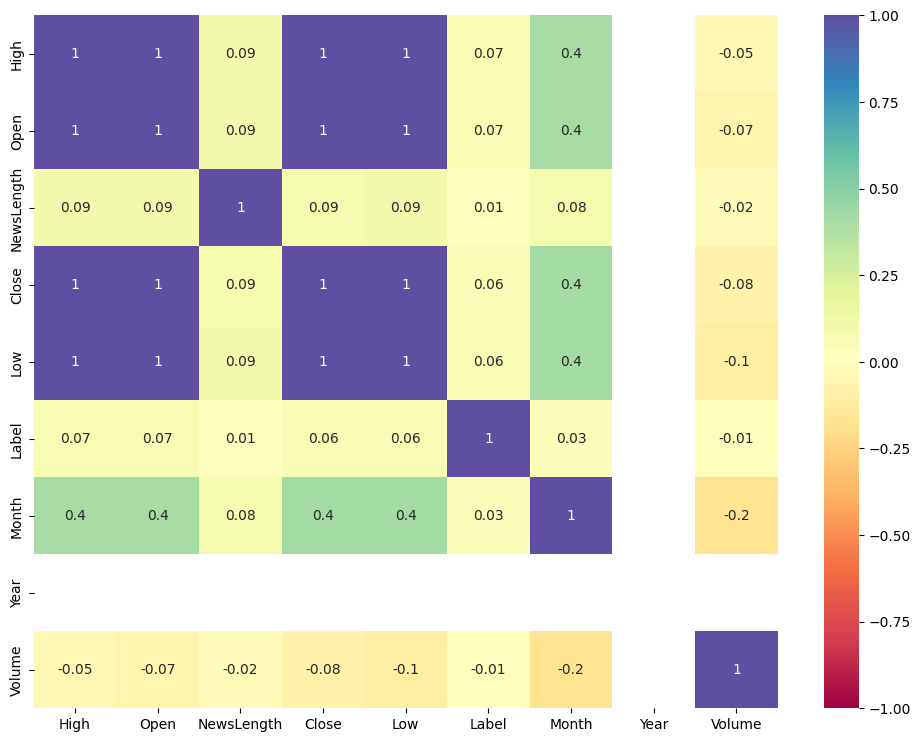

In [ ]:
plt.figure(figsize=(12,9))
sns.heatmap(data[['High','Open','NewsLength','Close','Low','Label','Month','Year','Volume']].corr(),annot=True,vmin=-1,vmax=1,fmt='.1g',cmap="Spectral")
plt.show()

- The High, Low, Open and Close prices all seem to correlate one-to-one in this dataset
- There seems to be a slight positive correlation between the Month and prices (high, low, open, close).

## **Text Preprocessing**

In [ ]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))

    return new_text

In [ ]:
# Applying the function to remove special characters
data['CleanedNews'] = data['News'].apply(remove_special_characters)

In [ ]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['News','CleanedNews']]

,News,CleanedNews
0,The tech sector experienced a significant dec...,The tech sector experienced a significant dec...
1,Apple lowered its fiscal Q1 revenue guidance ...,Apple lowered its fiscal Q1 revenue guidance ...
2,Apple cut its fiscal first quarter revenue fo...,Apple cut its fiscal first quarter revenue fo...
3,This news article reports that yields on long...,This news article reports that yields on long...


### Lowercasing

In [ ]:
# changing the case of the text data to lower case
data['CleanedNews'] = data['CleanedNews'].str.lower()

In [ ]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['News','CleanedNews']]

,News,CleanedNews
0,The tech sector experienced a significant dec...,the tech sector experienced a significant dec...
1,Apple lowered its fiscal Q1 revenue guidance ...,apple lowered its fiscal q1 revenue guidance ...
2,Apple cut its fiscal first quarter revenue fo...,apple cut its fiscal first quarter revenue fo...
3,This news article reports that yields on long...,this news article reports that yields on long...


### Removing extra whitespace

In [ ]:
# removing extra whitespaces from the text
data['CleanedNews'] = data['CleanedNews'].str.strip()

In [ ]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['News','CleanedNews']]

,News,CleanedNews
0,The tech sector experienced a significant dec...,the tech sector experienced a significant decl...
1,Apple lowered its fiscal Q1 revenue guidance ...,apple lowered its fiscal q1 revenue guidance t...
2,Apple cut its fiscal first quarter revenue fo...,apple cut its fiscal first quarter revenue for...
3,This news article reports that yields on long...,this news article reports that yields on long ...


### Removing stopwords

In [ ]:
# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])

    return new_text

In [ ]:
# Applying the function to remove stop words using the NLTK library
data['CleanedNews_NoStop'] = data['CleanedNews'].apply(remove_stopwords)

In [ ]:
# checking a couple of instances of cleaned data
data.loc[0:3,['CleanedNews','CleanedNews_NoStop']]

,CleanedNews,CleanedNews_NoStop
0,the tech sector experienced a significant decl...,tech sector experienced significant decline af...
1,apple lowered its fiscal q1 revenue guidance t...,apple lowered fiscal q1 revenue guidance 84 bi...
2,apple cut its fiscal first quarter revenue for...,apple cut fiscal first quarter revenue forecas...
3,this news article reports that yields on long ...,news article reports yields long dated u treas...


### Stemming

In [ ]:
# Loading the Porter Stemmer
ps = PorterStemmer()

In [ ]:
# defining a function to perform stemming
def apply_porter_stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([ps.stem(word) for word in words])

    return new_text

In [ ]:
# Applying the function to perform stemming
data['Final_News_Text'] = data['CleanedNews_NoStop'].apply(apply_porter_stemmer)

In [ ]:
# checking a couple of instances of cleaned data
data.loc[0:2,['CleanedNews_NoStop','Final_News_Text']]

,CleanedNews_NoStop,Final_News_Text
0,tech sector experienced significant decline af...,tech sector experienc signific declin aftermar...
1,apple lowered fiscal q1 revenue guidance 84 bi...,appl lower fiscal q1 revenu guidanc 84 billion...
2,apple cut fiscal first quarter revenue forecas...,appl cut fiscal first quarter revenu forecast ...


## **Word Embeddings**

### Word2Vec

In [ ]:
# creating a list of all words in our data
words_list = [item.split(" ") for item in data['Final_News_Text'].values]

In [ ]:
# Checking the words from the first five reviews
words_list[0:5]

[['tech',
  'sector',
  'experienc',
  'signific',
  'declin',
  'aftermarket',
  'follow',
  'appl',
  'q1',
  'revenu',
  'warn',
  'notabl',
  'supplier',
  'includ',
  'skywork',
  'broadcom',
  'lumentum',
  'qorvo',
  'tsmc',
  'saw',
  'stock',
  'drop',
  'respons',
  'appl',
  'downward',
  'revis',
  'revenu',
  'expect',
  'quarter',
  'previous',
  'announc',
  'januari'],
 ['appl',
  'lower',
  'fiscal',
  'q1',
  'revenu',
  'guidanc',
  '84',
  'billion',
  'earlier',
  'estim',
  '89',
  '93',
  'billion',
  'due',
  'weaker',
  'expect',
  'iphon',
  'sale',
  'announc',
  'caus',
  'signific',
  'drop',
  'appl',
  'stock',
  'price',
  'neg',
  'impact',
  'relat',
  'supplier',
  'lead',
  'broader',
  'market',
  'declin',
  'tech',
  'indic',
  'nasdaq',
  '10'],
 ['appl',
  'cut',
  'fiscal',
  'first',
  'quarter',
  'revenu',
  'forecast',
  '89',
  '93',
  'billion',
  '84',
  'billion',
  'due',
  'weaker',
  'demand',
  'china',
  'fewer',
  'iphon',
  'upgr

In [ ]:
# creating an instance of Word2Vec
model_W2V = Word2Vec(words_list, min_count = 1, workers = 6)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 2580


In [ ]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([-0.0117472 ,  0.02369875, -0.00295027,  0.00041055,  0.01223346,
       -0.03004118,  0.00795617,  0.04941738, -0.02522781, -0.00602165,
       -0.01987013, -0.03781078, -0.00081225,  0.01115419,  0.01322294,
       -0.02060808,  0.00555078, -0.02000766, -0.00698819, -0.05062392,
        0.00311736,  0.01139885,  0.00545486, -0.01286878, -0.00156488,
       -0.00381409, -0.01311084, -0.01304606, -0.02707667,  0.00396005,
        0.03424471,  0.00178841,  0.00052313, -0.01072019, -0.01628898,
        0.02161113, -0.0016387 , -0.0134837 , -0.01637847, -0.04600133,
       -0.00600931, -0.01729734, -0.0069105 ,  0.01247131,  0.02259912,
       -0.0028712 , -0.01224571, -0.00581799,  0.00712321,  0.01093129,
        0.01586263, -0.02361586, -0.01723468, -0.00571754, -0.02899162,
        0.00929232,  0.01446541, -0.00491875, -0.03201417,  0.00172412,
        0.01587596,  0.00655154, -0.00033183, -0.0032349 , -0.03653925,
        0.02189942,  0.00728486,  0.02202123, -0.03971837,  0.03

In [ ]:
# Checking top 5 similar words to the word 'increase'
similar = model_W2V.wv.similar_by_word('stock', topn=5)
print(similar)

[('compani', 0.94225013256073), ('year', 0.9414262175559998), ('appl', 0.9365116953849792), ('trade', 0.9314165711402893), ('price', 0.924325704574585)]


In [ ]:
# Checking top 5 similar words to the word 'price'
similar2 = model_W2V.wv.similar_by_word('market', topn=5)
print(similar2)

[('appl', 0.9319496154785156), ('year', 0.9266370534896851), ('trade', 0.9126262664794922), ('u', 0.9110774993896484), ('servic', 0.906114399433136)]


In [ ]:
# Dictionary with key as words and the value as the embedding vector.
words = model_W2V.wv.key_to_index

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(words[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
vec_size = 100
df_word2vec = pd.DataFrame(data['Final_News_Text'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_word2vec

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 90,Feature 91,Feature 92,Feature 93,Feature 94,Feature 95,Feature 96,Feature 97,Feature 98,Feature 99
0,585.312500,585.312500,585.312500,585.312500,585.312500,585.312500,585.312500,585.312500,585.312500,585.312500,...,585.312500,585.312500,585.312500,585.312500,585.312500,585.312500,585.312500,585.312500,585.312500,585.312500
1,181.405405,181.405405,181.405405,181.405405,181.405405,181.405405,181.405405,181.405405,181.405405,181.405405,...,181.405405,181.405405,181.405405,181.405405,181.405405,181.405405,181.405405,181.405405,181.405405,181.405405
2,353.350000,353.350000,353.350000,353.350000,353.350000,353.350000,353.350000,353.350000,353.350000,353.350000,...,353.350000,353.350000,353.350000,353.350000,353.350000,353.350000,353.350000,353.350000,353.350000,353.350000
3,302.588235,302.588235,302.588235,302.588235,302.588235,302.588235,302.588235,302.588235,302.588235,302.588235,...,302.588235,302.588235,302.588235,302.588235,302.588235,302.588235,302.588235,302.588235,302.588235,302.588235
4,538.685714,538.685714,538.685714,538.685714,538.685714,538.685714,538.685714,538.685714,538.685714,538.685714,...,538.685714,538.685714,538.685714,538.685714,538.685714,538.685714,538.685714,538.685714,538.685714,538.685714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,778.222222,778.222222,778.222222,778.222222,778.222222,778.222222,778.222222,778.222222,778.222222,778.222222,...,778.222222,778.222222,778.222222,778.222222,778.222222,778.222222,778.222222,778.222222,778.222222,778.222222
345,518.914286,518.914286,518.914286,518.914286,518.914286,518.914286,518.914286,518.914286,518.914286,518.914286,...,518.914286,518.914286,518.914286,518.914286,518.914286,518.914286,518.914286,518.914286,518.914286,518.914286
346,464.621622,464.621622,464.621622,464.621622,464.621622,464.621622,464.621622,464.621622,464.621622,464.621622,...,464.621622,464.621622,464.621622,464.621622,464.621622,464.621622,464.621622,464.621622,464.621622,464.621622
347,378.950000,378.950000,378.950000,378.950000,378.950000,378.950000,378.950000,378.950000,378.950000,378.950000,...,378.950000,378.950000,378.950000,378.950000,378.950000,378.950000,378.950000,378.950000,378.950000,378.950000


### GloVe

In [ ]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = '/content/drive/MyDrive/AIML/NLP/glove.6B.100d.txt.word2vec'
model_glove = KeyedVectors.load_word2vec_format(filename, binary=False)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(model_glove.index_to_key))

Length of the vocabulary is 400000


In [ ]:
# Checking the word embedding of a random word
word = "price"
model_glove[word]

array([ 3.3108e-01,  1.9364e-01,  1.6607e-01,  8.6574e-02, -2.0639e-01,
       -1.4334e+00, -2.9923e-01, -1.1618e-01, -6.6627e-01, -1.4150e-01,
        2.1907e-01,  1.6721e-01, -1.6150e-01, -2.8570e-01,  2.7179e-01,
        9.5956e-02, -9.7168e-01,  1.0444e-01,  1.0485e-01,  1.3673e-01,
        8.3398e-01, -6.8866e-01,  2.6409e-01,  2.9890e-01,  5.9473e-01,
        1.4549e-02,  1.7850e-02, -9.5206e-01, -6.6171e-01, -2.2428e-01,
        3.2354e-01,  5.7278e-01, -7.1502e-02, -1.4367e-01,  3.1574e-01,
        7.4511e-01,  7.5837e-01, -1.7850e-03,  1.0807e-01, -9.9260e-01,
        2.5383e-01, -5.2487e-01, -1.3455e-01, -3.1672e-01,  3.7978e-02,
        4.0723e-01, -5.5722e-01, -1.0508e+00,  5.0940e-03, -1.4605e+00,
        8.2840e-01, -1.4003e-01, -9.2980e-03,  8.4426e-01, -2.6589e-01,
       -2.1714e+00, -5.7227e-02, -1.6759e-01,  2.0411e+00, -2.6865e-01,
        4.3311e-01, -4.7494e-01, -8.3282e-01,  4.2100e-01,  3.4240e-01,
       -5.1296e-01,  6.7027e-01, -2.9009e-01,  7.7592e-01, -1.89

In [ ]:
#Returning the top 5 similar words.
result = model_glove.most_similar("price", topn=5)
print(result)

[('prices', 0.8554712533950806), ('value', 0.760714054107666), ('drop', 0.7485076785087585), ('stock', 0.7451035380363464), ('market', 0.7407819628715515)]


In [ ]:
#Returning the top 5 similar words.
result = model_glove.most_similar("increase", topn=5)
print(result)

[('increased', 0.8988391757011414), ('increases', 0.8812485337257385), ('decrease', 0.8812355399131775), ('increasing', 0.8467098474502563), ('reduce', 0.8099488615989685)]


In [ ]:
#List of words in the vocabulary
words = model_glove.index_to_key

In [ ]:
#Dictionary with key as the word and the value as the corresponding embedding vector.
word_vector_dict = dict(zip(model_glove.index_to_key,list(model_glove.vectors)))

In [ ]:
#Defining the dimension of the embedded vector.
vec_size=100

In [ ]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
df_glove = pd.DataFrame(data['Final_News_Text'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_glove

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 90,Feature 91,Feature 92,Feature 93,Feature 94,Feature 95,Feature 96,Feature 97,Feature 98,Feature 99
0,0.021671,0.096785,-0.047464,-0.066726,-0.215078,-0.603108,-0.089054,-0.001979,0.114239,-0.132121,...,-0.016118,0.282037,-0.146394,-0.217284,-0.137730,0.162514,0.208869,0.056668,0.186156,-0.025540
1,0.171825,0.341351,0.234650,-0.042054,-0.082840,-0.600302,-0.060674,-0.101788,-0.159387,0.023604,...,0.001762,0.271578,-0.190244,-0.136070,-0.442046,0.225178,0.175980,-0.036701,0.410090,-0.159631
2,0.010512,0.270341,0.301482,-0.087113,0.075485,-0.476547,-0.039534,-0.014161,-0.123561,-0.054536,...,0.113562,0.199301,-0.095302,-0.220799,-0.559601,0.130351,0.039756,-0.088995,0.484577,-0.204774
3,-0.147407,0.226970,0.377158,0.184659,-0.110523,-0.447424,-0.103314,0.033698,-0.021951,-0.041905,...,0.031969,0.314802,-0.276519,0.034750,-0.347012,0.131816,0.201519,-0.220721,0.328415,-0.101222
4,0.040798,0.198312,0.071460,0.037332,-0.098294,-0.407203,-0.078844,-0.102327,-0.132380,-0.031861,...,0.041134,0.188611,-0.051261,-0.364269,-0.216124,0.242409,0.243280,-0.071136,0.173813,-0.131392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,-0.133417,0.058861,0.415255,-0.291097,0.051498,0.079182,0.057609,0.127537,-0.074177,-0.070428,...,0.306373,-0.166262,0.083386,-0.120771,-0.347820,0.049615,-0.054991,-0.299478,0.437251,0.188692
345,0.159967,0.246612,0.288849,0.093632,0.043483,-0.284527,-0.167188,-0.049947,-0.246812,-0.088806,...,0.042174,0.246746,-0.054319,-0.047361,-0.572373,0.368322,0.077437,0.020181,0.441181,0.015956
346,0.043433,0.127144,0.151791,-0.053902,-0.067352,-0.187623,-0.020754,0.138385,-0.354622,-0.084654,...,-0.066027,0.240859,-0.119884,-0.026659,-0.428011,0.054745,-0.025141,-0.129436,0.258558,-0.027775
347,-0.098248,0.090049,0.181622,-0.028409,-0.128997,-0.497643,-0.247336,-0.034014,-0.103773,-0.195073,...,0.012848,0.070933,-0.053851,-0.265540,-0.415342,0.111974,0.295720,-0.207213,0.378713,0.026234


#### Embedding matrix using Sentence Transformers

In [ ]:
# defining the model
model_transformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# encoding the dataset
embedding_matrix = model_transformer.encode(data['Final_News_Text'], device=device, show_progress_bar=True)

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
# printing the shape of the embedding matrix
embedding_matrix.shape

(349, 384)

In [ ]:
# printing the embedding vector of the first review in the dataset
embedding_matrix[0,:]

array([-4.35230695e-02, -3.29503976e-02,  1.18766148e-02, -2.81183925e-02,
       -4.92299534e-02, -3.22516337e-02,  6.49221763e-02,  8.59606490e-02,
       -5.15833730e-03, -7.01667834e-03,  6.41608015e-02,  6.85859285e-03,
        5.48726553e-03, -1.17762806e-02, -2.30298992e-02, -6.20182082e-02,
        3.91359394e-03, -3.52361649e-02, -8.98560211e-02, -6.32310733e-02,
       -4.57198322e-02, -7.06844702e-02, -5.99571057e-02,  2.73746345e-02,
       -1.07715549e-02, -3.64985913e-02,  1.46401115e-02,  7.55968764e-02,
        4.79061380e-02, -1.22141346e-01, -5.15049398e-02,  1.34289786e-01,
        4.91506085e-02,  3.63531373e-02,  1.16165606e-02,  1.05563970e-02,
       -6.83268066e-04, -4.49276641e-02,  4.31670547e-02, -1.22120110e-02,
       -5.07503189e-02, -8.38373154e-02, -1.05264351e-01, -5.41449077e-02,
        7.20376596e-02, -6.95498735e-02, -4.93149012e-02,  2.94029005e-02,
        8.44291672e-02,  1.61984358e-02, -2.72224601e-02,  5.01877442e-02,
        6.29155431e-03,  

## Data Pre-processing

#### Splitting the dataset

In [ ]:
# Creating dependent and independent variables
X_word2vec = df_word2vec.copy()
X_glove = df_glove.copy()
X_transformer = embedding_matrix.copy()
y = data['Label']

In [ ]:
def split(X,y):
    # Initial split into training (80%) and testing (20%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

    # Further split the temporary set into validation (10%) and test (10%) sets
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [ ]:
#Splitting the dataset.
X_train_word2vec,X_valid_word2vec,X_test_word2vec,y_train_word2vec,y_valid_word2vec,y_test_word2vec=split(X_word2vec,y)
X_train_glove,X_valid_glove,X_test_glove,y_train_glove,y_valid_glove,y_test_glove=split(X_glove,y)
X_train_transformer, X_valid_transformer, X_test_transformer, y_train_transformer, y_valid_transformer, y_test_transformer = split(X_transformer, y)

## **Sentiment Analysis**

###### Rationale for model evaluation criteria

- The cost of false negatives as well as false postives might be considered high in case of stock decisions - a decision to buy or sell a stock both might turn out expensive for a customer and thus affecting the company's credibility
- Hence we need to make sure to avoid both false negatives and false positives. So going for F1 score as the metric of choice.


#### Model Building

In [ ]:
# creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = encoder.classes_.tolist()
    sns.heatmap(cm, annot = True,  fmt = '.0f',cmap='Blues', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

### Random Forest with Word2Vec

#### RF Base model

- The encoder changes the labels into 0, 1 and 2 from -1, 0 and 1 correspondingly.

In [ ]:
# Label Encoding
encoder = LabelEncoder()

# fitting the encoder to the training labels
y_train_enc_word2vec = encoder.fit_transform(y_train_word2vec)

# applying the encoder mapping from training labels to test labels
y_test_enc_word2vec = encoder.transform(y_test_word2vec)

In [ ]:
# Building the model
rf_word2vec_base = RandomForestClassifier(class_weight = "balanced",random_state = 42)

# Fitting on train data
rf_word2vec_base.fit(X_train_word2vec, y_train_enc_word2vec)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Predicting on train data
y_pred_train_base_w2v = rf_word2vec_base.predict(X_train_word2vec)

# Predicting on test data
y_pred_test_base_w2v = rf_word2vec_base.predict(X_test_word2vec)

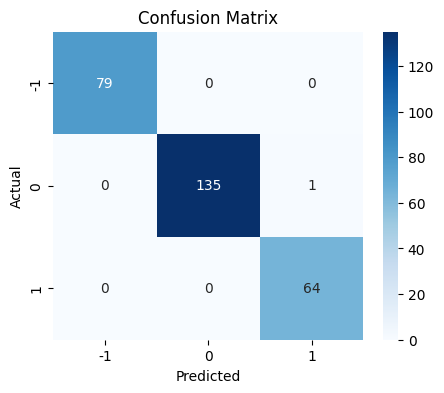

In [ ]:
plot_confusion_matrix(y_train_enc_word2vec, y_pred_train_base_w2v)

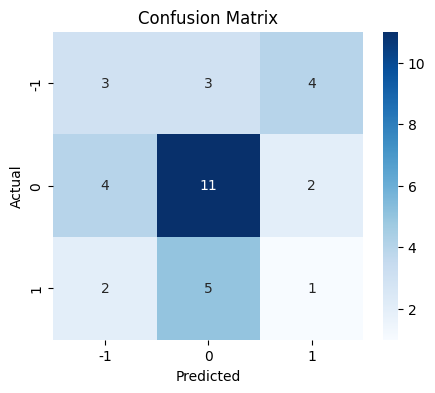

In [ ]:
plot_confusion_matrix(y_test_enc_word2vec, y_pred_test_base_w2v)

In [ ]:
#Calculating different metrics on training data
word2vec_base_train=model_performance_classification_sklearn(rf_word2vec_base, X_train_word2vec,y_train_enc_word2vec)
print("Training performance:\n", word2vec_base_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.996416  0.996416   0.996471  0.996423


In [ ]:
#Calculating different metrics on training data
word2vec_base_test=model_performance_classification_sklearn(rf_word2vec_base, X_test_word2vec,y_test_enc_word2vec)
print("Testing performance:\n", word2vec_base_test)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.409094  0.417527


This seems to be overfitting the training data. Lets see if hyper parameter tuning will help.

#### RF model with Grid Search

- For the hyperparameter tuning, adding class_weights to balance out the dataset.
- Determined the class_weight numbers based on % of each label.


In [ ]:
# Choose the type of classifier.
word2vec_rf_tuned = RandomForestClassifier(random_state=1,bootstrap=True)

parameters = {
    'max_depth': list(np.arange(5, 10, 2)),
    'n_estimators': np.arange(50, 110, 25),
    'max_features': [0.3, 0.4],
    'class_weight': [{0: 1.18, 1: 0.69, 2: 1.47}, 'balanced', None]  # Add your custom weights here
}


# Run the grid search
grid_obj = GridSearchCV(word2vec_rf_tuned, parameters, scoring='f1',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_word2vec, y_train_enc_word2vec)

# Set the clf to the best combination of parameters
word2vec_rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
word2vec_rf_tuned.fit(X_train_word2vec, y_train_enc_word2vec)

RandomForestClassifier(class_weight={0: 1.18, 1: 0.69, 2: 1.47}, max_depth=5,
                       max_features=0.3, n_estimators=50, random_state=1)

- GridSearch picks up the class_weights parameter. So it does improve the model.

In [ ]:
# Predicting on train data
y_pred_train_tuned_w2v = word2vec_rf_tuned.predict(X_train_word2vec)

# Predicting on test data
y_pred_test_tuned_w2v = word2vec_rf_tuned.predict(X_test_word2vec)

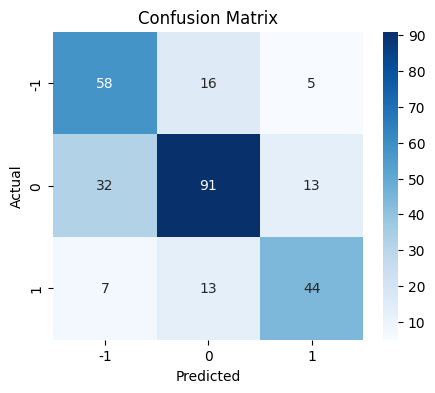

In [ ]:
plot_confusion_matrix(y_train_enc_word2vec, y_pred_train_tuned_w2v)

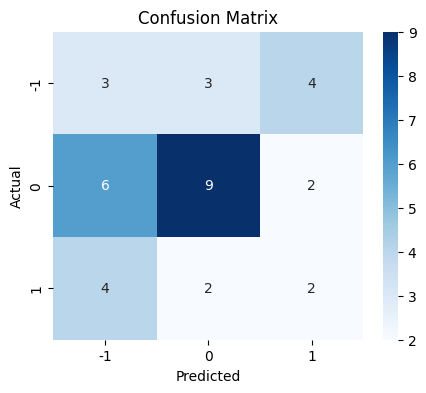

In [ ]:
plot_confusion_matrix(y_test_enc_word2vec, y_pred_test_tuned_w2v)

In [ ]:
#Calculating different metrics on training data
word2vec_tuned_train=model_performance_classification_sklearn(word2vec_rf_tuned, X_train_word2vec,y_train_enc_word2vec)
print("Training performance:\n", word2vec_tuned_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.691756  0.691756   0.701756  0.693384


In [ ]:
#Calculating different metrics on training data
word2vec_tuned_test=model_performance_classification_sklearn(word2vec_rf_tuned, X_test_word2vec,y_test_enc_word2vec)
print("Testing performance:\n", word2vec_tuned_test)

Testing performance:
    Accuracy  Recall  Precision        F1
0       0.4     0.4   0.435322  0.413705


- Tuning parameters using word2vec embeddings reduced the overfitting. But did not particularly do a good fit. Test performance is not particularly good either.

### Random Forest with GloVe

In [ ]:
# Label Encoding
encoder = LabelEncoder()

# fitting the encoder to the training labels
y_train_enc_glove = encoder.fit_transform(y_train_glove)

# applying the encoder mapping from training labels to test labels
y_test_enc_glove = encoder.transform(y_test_glove)

#### RF Base model

In [ ]:
# Building the model
rf_glovec_base = RandomForestClassifier(class_weight= "balanced",random_state = 42)

# Fitting on train data
rf_glovec_base.fit(X_train_glove, y_train_enc_glove)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Predicting on train data
y_pred_train_base_gl = rf_glovec_base.predict(X_train_glove)

# Predicting on test data
y_pred_test_base_gl = rf_glovec_base.predict(X_test_glove)

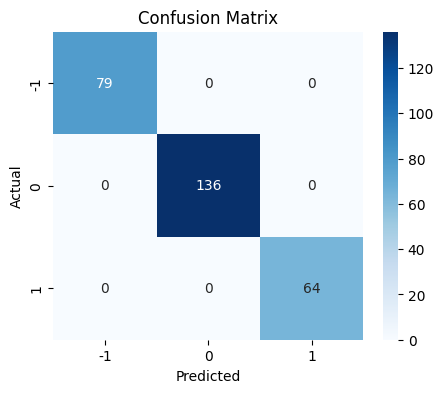

In [ ]:
plot_confusion_matrix(y_train_enc_glove, y_pred_train_base_gl)

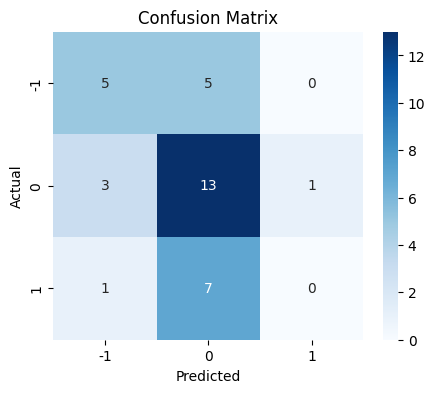

In [ ]:
plot_confusion_matrix(y_test_enc_glove, y_pred_test_base_gl)

In [ ]:
#Calculating different metrics on training data
glove_base_train=model_performance_classification_sklearn(rf_glovec_base, X_train_glove,y_train_enc_glove)
print("Training performance:\n", glove_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on training data
glove_base_test=model_performance_classification_sklearn(rf_glovec_base, X_test_glove,y_test_enc_glove)
print("Testing performance:\n", glove_base_test)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.514286  0.514286   0.411302  0.451056


- Again the base RF model overfitting with the GloVe embeddings too.

#### RF model with Grid Search

In [ ]:
# Choose the type of classifier.
glove_rf_tuned = RandomForestClassifier(random_state=1,bootstrap=True)

parameters = {
    'max_depth': list(np.arange(5, 10, 2)),
    'n_estimators': np.arange(50, 110, 25),
    'max_features': [0.3, 0.4],
    'class_weight': [{0: 1.18, 1: 0.69, 2: 1.47}, 'balanced', None]  # Add your custom weights here
}

# Run the grid search
grid_obj = GridSearchCV(glove_rf_tuned, parameters, scoring='f1',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_glove, y_train_enc_glove)

# Set the clf to the best combination of parameters
glove_rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
glove_rf_tuned.fit(X_train_glove, y_train_enc_glove)

RandomForestClassifier(class_weight={0: 1.18, 1: 0.69, 2: 1.47}, max_depth=5,
                       max_features=0.3, n_estimators=50, random_state=1)

In [ ]:
# Predicting on train data
y_pred_train_tuned_gl = glove_rf_tuned.predict(X_train_glove)

# Predicting on test data
y_pred_test_tuned_gl = glove_rf_tuned.predict(X_test_glove)

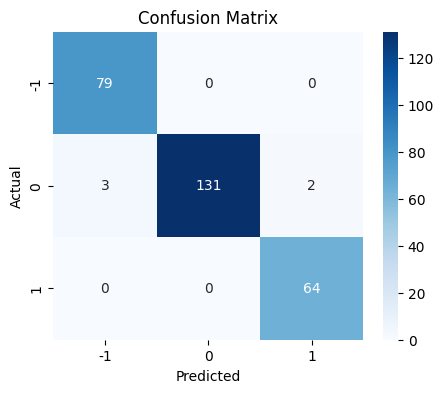

In [ ]:
plot_confusion_matrix(y_train_enc_glove, y_pred_train_tuned_gl)

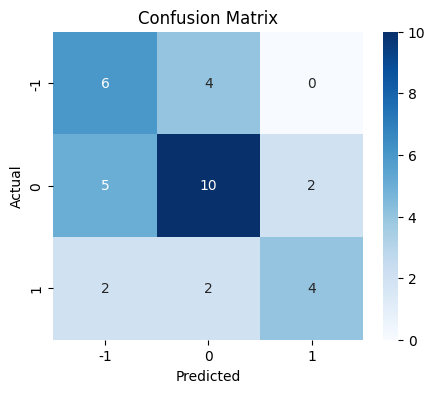

In [ ]:
plot_confusion_matrix(y_test_enc_glove, y_pred_test_tuned_gl)

In [ ]:
#Calculating different metrics on training data
glove_tuned_train=model_performance_classification_sklearn(glove_rf_tuned, X_train_glove,y_train_enc_glove)
print("Training performance:\n", glove_tuned_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.982079  0.982079   0.982689  0.982066


In [ ]:
#Calculating different metrics on training data
glove_tuned_test=model_performance_classification_sklearn(glove_rf_tuned, X_test_glove,y_test_enc_glove)
print("Testing performance:\n", glove_tuned_test)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.587821  0.574053


- Better fit on the training as well as test data using this tuned parameters

#### RF Model with Sentence Transformers

In [ ]:
# Label Encoding
encoder = LabelEncoder()

# fitting the encoder to the training labels
y_train_enc_transformer = encoder.fit_transform(y_train_transformer)

# applying the encoder mapping from training labels to test labels
y_test_enc_transformer = encoder.transform(y_test_transformer)

In [ ]:
# Building the model
transformer_rf_base = RandomForestClassifier(n_estimators = 100, max_depth = 7, random_state = 42)

# Fitting on train data
transformer_rf_base.fit(X_train_transformer, y_train_enc_transformer)

RandomForestClassifier(max_depth=7, random_state=42)

In [ ]:
# Predicting on train data
y_pred_transformer_train = transformer_rf_base.predict(X_train_transformer)

# Predicting on test data
y_pred_transformer_test = transformer_rf_base.predict(X_test_transformer)

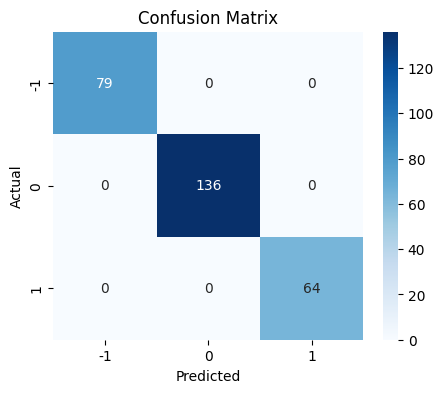

In [ ]:
plot_confusion_matrix(y_train_enc_transformer, y_pred_transformer_train)

In [ ]:
print(classification_report(y_train_enc_transformer, y_pred_transformer_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00       136
           2       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



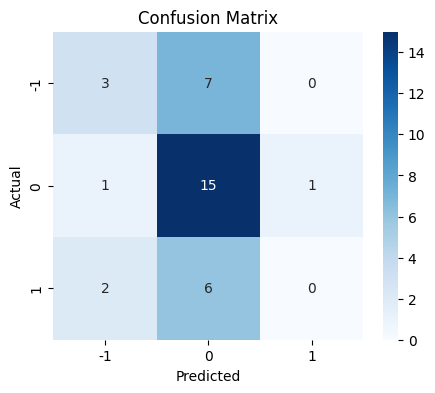

In [ ]:
plot_confusion_matrix(y_test_enc_transformer, y_pred_transformer_test)

In [ ]:
#Calculating different metrics on training data
transformer_base_train=model_performance_classification_sklearn(transformer_rf_base, X_train_transformer,y_train_enc_transformer)
print("Training performance:\n", transformer_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on test data
transformer_base_test=model_performance_classification_sklearn(transformer_rf_base, X_test_transformer,y_test_enc_transformer)
print("Training performance:\n", transformer_base_test)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.514286  0.514286   0.403061  0.430952


- Overfit training data again.

#### RF Model with Sentence Transformers - Grid Search

In [ ]:
# Choose the type of classifier.
transformer_rf_tuned = RandomForestClassifier(random_state=1,bootstrap=True)

parameters = {
    'max_depth': list(np.arange(5, 10, 2)),
    'n_estimators': np.arange(50, 110, 25),
    'max_features': [0.3, 0.4],
    'class_weight': [{0: 1.18, 1: 0.69, 2: 1.47}, 'balanced', None]  # Add your custom weights here
}

# Run the grid search
grid_obj = GridSearchCV(transformer_rf_tuned, parameters, scoring='f1',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_transformer, y_train_enc_transformer)

# Set the clf to the best combination of parameters
transformer_rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
transformer_rf_tuned.fit(X_train_transformer, y_train_enc_transformer)

RandomForestClassifier(class_weight={0: 1.18, 1: 0.69, 2: 1.47}, max_depth=5,
                       max_features=0.3, n_estimators=50, random_state=1)

In [ ]:
# Predicting on train data
y_pred_train_tuned_tf = transformer_rf_tuned.predict(X_train_transformer)

# Predicting on test data
y_pred_test_tuned_tf = transformer_rf_tuned.predict(X_test_transformer)

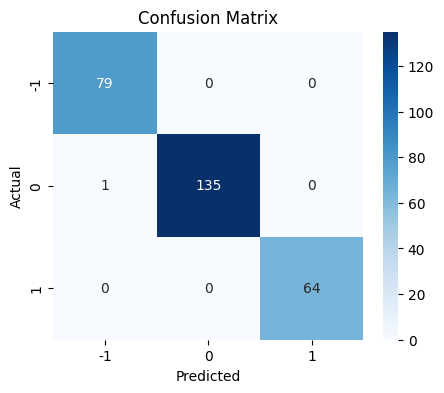

In [ ]:
plot_confusion_matrix(y_train_enc_transformer, y_pred_train_tuned_tf)

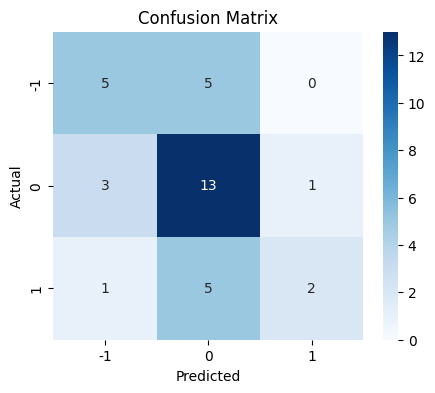

In [ ]:
plot_confusion_matrix(y_test_enc_transformer, y_pred_test_tuned_tf)

In [ ]:
#Calculating different metrics on training data
transformer_tuned_train=model_performance_classification_sklearn(transformer_rf_tuned, X_train_transformer,y_train_enc_transformer)
print("Training performance:\n", transformer_tuned_train)

Training performance:
    Accuracy    Recall  Precision       F1
0  0.996416  0.996416   0.996461  0.99642


In [ ]:
#Calculating different metrics on training data
transformer_tuned_test=model_performance_classification_sklearn(transformer_rf_tuned, X_test_transformer,y_test_enc_transformer)
print("Testing performance:\n", transformer_tuned_test)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.585645  0.549207


### Pre-Trained Transformers

##### FLAN-T5

In [ ]:
# Defining the input and target variables
X = data['Final_News_Text']
y = data["Label"]

In [ ]:
# initializing a T5 tokenizer using the pre-trained model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
# initializing a T5 model for conditional generation using the pre-trained model "google/flan-t5-large"
T5model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", load_in_8bit=True, device_map="auto")

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# defining a function to generate, process, and return a response
def generate_response(prompt):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")    ### using the tokenizer to create tokens in tensor format from an input
    outputs = T5model.generate(input_ids, max_length=16, do_sample=True, temperature=0.001)    ### generating the model output in tensor format
    return tokenizer.decode(outputs[0])[6:-4]    ### using the tokenizer to decode the model output, and then return it

In [ ]:
# checking a customer review and it's sentiment
print('News:\t', X[4])
print('Actual Sentiment:\t', y[4])

News:	 appl revenu warn led declin usd jpi pair gain japanes yen investor sought safeti highli liquid currenc appl underperform q1 forecast revenu 84 billion compar analyst expect 91 5 billion trigger risk avers mood market
Actual Sentiment:	 -1


In [ ]:
# defining a prompt which tells the model what to do
sys_prompt = """
    Categorize the sentiment of the news article as positive or negative or neutral.
    Return -1 for negative, 0 for neutral and 1 for positive
"""

# predicting the sentiment using the model by incorporating the system prompt and the provided review text

pred_sent = generate_response(
    """
        {}
        News text: '{}'
    """.format(sys_prompt, X[4])
)

print(pred_sent)

-1


In [ ]:
# defining a function to generate a sentiment prediction
def predict_sentiment(news_text):
    pred = generate_response(
        """
            {}
            News text: '{}'
        """.format(sys_prompt, news_text)
    )

    return int(pred)

In [ ]:
# making predictions with the model
predicted_sentiment = [predict_sentiment(X[item]) for item in range(len(X))]

predicted_sentiment_df = pd.DataFrame(predicted_sentiment, columns=['Label'])


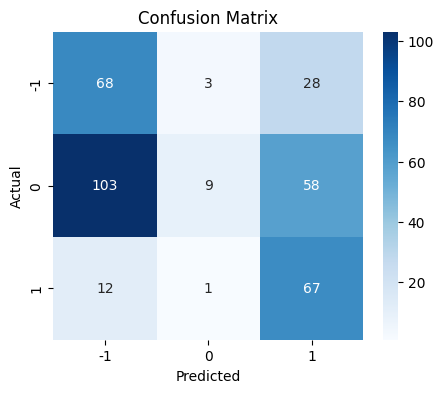

In [ ]:
# Label Encoding
encoder = LabelEncoder()

# fitting the encoder to the training labels
y_enc = encoder.fit_transform(y)
predicted_sentiment_df_enc = encoder.fit_transform(predicted_sentiment_df)

plot_confusion_matrix(y_enc, predicted_sentiment_df_enc)

In [ ]:
print(classification_report(y_enc, predicted_sentiment_df_enc))

              precision    recall  f1-score   support

           0       0.37      0.69      0.48        99
           1       0.69      0.05      0.10       170
           2       0.44      0.84      0.58        80

    accuracy                           0.41       349
   macro avg       0.50      0.53      0.39       349
weighted avg       0.54      0.41      0.32       349



##### BERT

- Want to try a model that is fine tuned on stock news data. Picking this finbert model from HuggingFace

In [ ]:
# Defining the input and target variables
X = data['News']
y = data["Label"]

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

finbert_pipe = pipeline("text-classification", model="ProsusAI/finbert")

# Checking output for 1 record
data_0 = data.iloc[0]
predicted_sentiment_finbert_0 = finbert_pipe(data_0['News'])
print('News:', data_0['News'], '\n Sentiment:',predicted_sentiment_finbert_0[0]['label'])


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


News:  The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January. 
 Sentiment: negative


- Sentiment seems right. Next we try for all data and compare with y.

In [ ]:
predicted_sentiment_finbert = [finbert_pipe(item) for item in data['News']]

In [ ]:
label_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}

# Extract 'label' values from each dictionary in the nested list and map them
labels = [label_mapping[item[0]['label']] for item in predicted_sentiment_finbert]

# Assign the mapped labels to the DataFrame
predicted_sentiment_finbert_df = pd.DataFrame()
predicted_sentiment_finbert_df['Label'] = labels

print(predicted_sentiment_finbert_df)


     Label
0       -1
1       -1
2       -1
3       -1
4       -1
..     ...
344      0
345     -1
346      1
347      1
348     -1

[349 rows x 1 columns]


In [ ]:
# Label Encoding
encoder = LabelEncoder()

# fitting the encoder to the training labels
y_enc = encoder.fit_transform(y)
pred_sentiment_finbert_df_enc = encoder.fit_transform(predicted_sentiment_finbert_df)

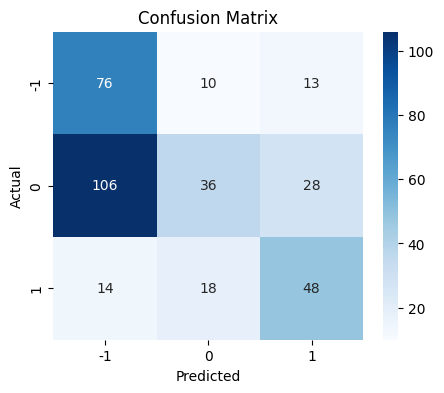

In [ ]:
plot_confusion_matrix(y_enc, pred_sentiment_finbert_df_enc)

In [ ]:
print(classification_report(y_enc, pred_sentiment_finbert_df_enc))

              precision    recall  f1-score   support

           0       0.39      0.77      0.52        99
           1       0.56      0.21      0.31       170
           2       0.54      0.60      0.57        80

    accuracy                           0.46       349
   macro avg       0.50      0.53      0.46       349
weighted avg       0.51      0.46      0.43       349



- That doesn't look particularly great. It doesn't seem better than the GloVe model which has F1 score of 57.

#### Model Comparison and Final Model Selection

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [word2vec_base_train.T,word2vec_tuned_train.T,glove_base_train.T,glove_tuned_train.T,
     transformer_base_train.T, transformer_tuned_train.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Word2vec - Base RF Model",
    "Word2vec - RF with Grid Search",
    "GloVe - Base RF Model",
    "GloVe - RF with Grid Search",
    "Sentence Transformer - Base RF Model",
    "Sentence Transformer - RF with Grid Search"]
print("Training performance comparison:")

models_train_comp_df

Training performance comparison:


,Word2vec - Base RF Model,Word2vec - RF with Grid Search,GloVe - Base RF Model,GloVe - RF with Grid Search,Sentence Transformer - Base RF Model,Sentence Transformer - RF with Grid Search
Accuracy,0.996416,0.691756,1.0,0.982079,1.0,0.996416
Recall,0.996416,0.691756,1.0,0.982079,1.0,0.996416
Precision,0.996471,0.701756,1.0,0.982689,1.0,0.996461
F1,0.996423,0.693384,1.0,0.982066,1.0,0.996420


In [ ]:
# test performance comparison

models_test_comp_df = pd.concat(
    [word2vec_base_test.T,word2vec_tuned_test.T,glove_base_test.T,glove_tuned_test.T,
     transformer_base_test.T, transformer_tuned_test.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Word2vec - Base RF Model",
    "Word2vec - RF with Grid Search",
    "GloVe - Base RF Model",
    "GloVe - RF with Grid Search",
    "Sentence Transformer - Base RF Model",
    "Sentence Transformer - RF with Grid Search"]
print("Testing performance comparison:")

models_test_comp_df

Testing performance comparison:


,Word2vec - Base RF Model,Word2vec - RF with Grid Search,GloVe - Base RF Model,GloVe - RF with Grid Search,Sentence Transformer - Base RF Model,Sentence Transformer - RF with Grid Search
Accuracy,0.428571,0.400000,0.514286,0.571429,0.514286,0.571429
Recall,0.428571,0.400000,0.514286,0.571429,0.514286,0.571429
Precision,0.409094,0.435322,0.411302,0.587821,0.403061,0.585645
F1,0.417527,0.413705,0.451056,0.574053,0.430952,0.549207


- From the above results, the GloVe tuned model (**GloVe - RF with Grid Search**) gives the most generalized F1 score (57).
- The Pretrained sentence transformer model (FANT5) as well didn't give better F1 score (32).
- So choosing the **"GloVe - RF with Grid Search"** model - tuned with below hyperparameters chosen as the best estimator parameters from the GridSearch

> `RandomForestClassifier(class_weight={0: 1.18, 1: 0.69, 2: 1.47}, max_depth=5, max_features=0.3, n_estimators=50, random_state=1)`




## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!apt-get install -y build-essential
!pip install --upgrade pip setuptools wheel

!pip install scikit-build-core==0.9.0
!CMAKE_ARGS="-DLLAMA_CUBLAS=on -DCMAKE_CUDA_ARCHITECTURES=61" FORCE_CMAKE=1 pip install llama-cpp-python==0.2.62 --force-reinstall --upgrade --no-cache-dir --verbose --no-build-isolation

#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Using pip 24.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 111.9 MB/s eta 0:00:00
  Running command Preparing metadata (pyproject.toml)
  *** scikit-build-core 0.9.0 using CMake 3.30.5 (metadata_wheel)
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for typing-extensions>=4.5.0 from https://files.pythonhosted.org/packages/26/9f/ad63fc0248c5379346306f8668cda6e2e2e9c95e01216d2b8ffd9ff037d0/typing_extensions-4.12.2-py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.20.0 from https://files.pythonhosted.org/packages/fb/25/ba023652a39a2c127200e85aed975fc6119b421e2c348e5d0171e2046edb/numpy-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for diskcache>=5.6.1 from https://files.pythonhosted.org/packages/3f/27/4570e78fc0bf5ea0ca45eb1de3818a23787af9b390c0b0a0033a1b8236f9/diskcache-5.6.3-py3-none-any.whl.

In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [ ]:
# loading the dataset
data = pd.read_csv("/content/drive/MyDrive/AIML/NLP/stock_news.csv")

#### Loading the model

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
model_basename = "llama-2-13b-chat.Q5_K_M.gguf" # the model is in gguf format

In [ ]:
# Using hf_hub_download to download a model from the Hugging Face model hub
# The repo_id parameter specifies the model name or path in the Hugging Face repository
# The filename parameter specifies the name of the file to download
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

llama-2-13b-chat.Q5_K_M.gguf:   0%|          | 0.00/9.23G [00:00<?, ?B/s]

- After first execution, saw that we need a broader context window. 4096 wasn't enough. Increasing it to 6000.

In [ ]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,  # CPU cores
    n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=43,  # Change this value based on your model and your GPU VRAM pool.
    n_ctx=6000,  # Context window
)

llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from /root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/snapshots/4458acc949de0a9914c3eab623904d4fe999050a/llama-2-13b-chat.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 13824
llama_model_loader: - kv   6:                 llama.rope.dimension_

#### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [ ]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [ ]:
# creating a copy of the data
data_grouped_weekly = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
def generate_llama_response(instruction, news_text):

    # System message explicitly instructing not to include the review text
    system_message = """
        [INST]<<SYS>>
        {}
        <</SYS>>[/INST]
    """.format(instruction)

    # Combine user_prompt and system_message to create the prompt
    prompt = f"{news_text}\n{system_message}"

    # Generate a response from the LLaMA model
    response = lcpp_llm(
        prompt=prompt,
        max_tokens=1024,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        top_k=50,
        stop=['INST'],
        echo=False,
        seed=42,
    )

    # Extract the sentiment from the response
    response_text = response["choices"][0]["text"]

    return response_text

##### Defining the instruction

In [ ]:
# defining the instructions for the model
instruction = """
  Role: You are an expert data analyst specializing in financial news content analysis.
  You are provided a text input that has multiple news articles published in a week.

  Task: Analyze the input text. Generate a JSON response as per the instructions below.

  Instructions:
  1. Read the text input carefully.
  2. Split the text into multiple events using || as the delimiter.
  3. Identify the overall sentiment for the week as "Weekly_Sentiment" as positive, negative or neutral.
  4. Identify the top 3 positive and negative events from the week that might affect the stock price.
  5. List the top 3 positive and negative events as "Top_3_Positive" and "Top_3_Negative".
  6. Summarize the week's news in a concise manner as "Summary".

  Output should be a JSON in the below format
    {
        "Weekly_Sentiment": "your_sentiment_prediction",
        "Top_3_Positive": "your_top3_positive_news",
        "Top_3_Negative": "your_top3_negative_news",
        "Summary": "your_summary_prediction"
    }

  Return only the JSON output, no other extra text.

"""

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [ ]:
data_grouped_weekly_0 = data_grouped_weekly.iloc[0]

In [ ]:
data_grouped_weekly_0 = data_grouped_weekly_0.to_frame(name='News')

In [ ]:
print(type(data_grouped_weekly_0))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
data_grouped_weekly_0['News']

Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
temp_summary = data_grouped_weekly_0['News'].apply(
    lambda x: generate_llama_response(instruction, x).replace('\n', '')
)
data_grouped_weekly_0['Summary'] = temp_summary[0]

Llama.generate: prefix-match hit

llama_print_timings:        load time =   10504.16 ms
llama_print_timings:      sample time =      78.00 ms /   138 runs   (    0.57 ms per token,  1769.32 tokens per second)
llama_print_timings: prompt eval time =     141.18 ms /   355 tokens (    0.40 ms per token,  2514.56 tokens per second)
llama_print_timings:        eval time =    2000.54 ms /   137 runs   (   14.60 ms per token,    68.48 tokens per second)
llama_print_timings:       total time =    2581.06 ms /   492 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =   10504.16 ms
llama_print_timings:      sample time =     355.67 ms /   697 runs   (    0.51 ms per token,  1959.68 tokens per second)
llama_print_timings: prompt eval time =    1547.52 ms /  4372 tokens (    0.35 ms per token,  2825.16 tokens per second)
llama_print_timings:        eval time =   12406.87 ms /   696 runs   (   17.83 ms per token,    56.10 tokens per second)
llama_print_timings:       to

In [ ]:
print(type(data_grouped_weekly_0))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
data_grouped_weekly_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, Date to News
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   News     2 non-null      object
 1   Summary  2 non-null      object
dtypes: object(2)
memory usage: 156.0+ bytes


In [ ]:
pd.options.display.max_colwidth = None
data_grouped_weekly_0['Summary']
data_grouped_weekly_0.reset_index(inplace=True)

In [ ]:
data_grouped_weekly_0

index  \
0  Date   
1  News   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [ ]:
# Apply the extract_json_data function to each entry in the 'summary' column
t = extract_json_data(data_grouped_weekly_0['Summary'][1])


In [ ]:
t

{'Weekly_Sentiment': 'neutral',
 'Top_3_Positive': ['Company XYZ announces new product line',
  'Industry expert predicts growth in sector'],
 'Top_3_Negative': ['Economic uncertainty affects stock prices',
  'Regulatory changes may impact industry profitability'],
 'Summary': 'Mixed news for the week, with some positive developments in product launches and industry outlook, but also concerns about economic and regulatory headwinds.'}

##### Checking the model output on the weekly data

In [ ]:
temp_summary_full = data_grouped_weekly['News'].apply(
    lambda x: generate_llama_response(instruction, x).replace('\n', '')
)

Llama.generate: prefix-match hit

llama_print_timings:        load time =   10504.16 ms
llama_print_timings:      sample time =     432.02 ms /   899 runs   (    0.48 ms per token,  2080.92 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   16124.85 ms /   899 runs   (   17.94 ms per token,    55.75 tokens per second)
llama_print_timings:       total time =   19715.27 ms /   900 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =   10504.16 ms
llama_print_timings:      sample time =      19.21 ms /    33 runs   (    0.58 ms per token,  1718.03 tokens per second)
llama_print_timings: prompt eval time =     905.72 ms /  2700 tokens (    0.34 ms per token,  2981.04 tokens per second)
llama_print_timings:        eval time =     526.15 ms /    32 runs   (   16.44 ms per token,    60.82 tokens per second)
llama_print_timings:       to

In [ ]:
temp_summary_full
#data_grouped_weekly["summarized_news_parsed"] = data_grouped_weekly["summarized_news"].apply(extract_json_data)
#data_grouped_weekly["summarized_news_parsed"]

0      The input text">       Apple's stock price target="Apple's>                    "Weekly sentiment">                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ally                                                                                                                                                                                                                                                                                ually                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
temp_extracted_summary = []

for i in range(len(temp_summary_full)):
  temp_extracted_summary.append(extract_json_data(temp_summary_full[i]))


##### Formatting the model output

In [ ]:
temp_extracted_summary

[{},
 {},
 {'Weekly_Sentiment': 'neutral',
  'Top_3_Positive': ["Apple's new iPhone 14 features receive positive reviews",
   "Tesla's stock price surges after announcing a surprise profit"],
  'Top_3_Negative': ["China's economy slowdown affects global markets, causing stock prices to plummet",
   'Trade tensions between the US and China escalate as both countries impose new tariffs'],
  'Summary': "This week saw a mix of positive and negative news in the financial world. Apple's new iPhone features received praise from critics, while Tesla's surprise profit announcement boosted its stock price. However, global markets were affected by China's economic slowdown and trade tensions between the US and China continued to escalate."},
 {'Weekly_Sentiment': 'neutral',
  'Top_3_Positive': ["IBM's stock price increased after hours due to better-than-expected earnings and revenue, with its cloud computing business contributing positively.",
   'Apple is considering Tianjin Lishen as a potentia

In [ ]:
data_grouped_weekly_df = pd.json_normalize(temp_extracted_summary)



data_grouped_weekly_df.head()

,Weekly_Sentiment,Top_3_Positive,Top_3_Negative,Summary
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,neutral,"[Apple's new iPhone 14 features receive positive reviews, Tesla's stock price surges after announcing a surprise profit]","[China's economy slowdown affects global markets, causing stock prices to plummet, Trade tensions between the US and China escalate as both countries impose new tariffs]","This week saw a mix of positive and negative news in the financial world. Apple's new iPhone features received praise from critics, while Tesla's surprise profit announcement boosted its stock price. However, global markets were affected by China's economic slowdown and trade tensions between the US and China continued to escalate."
3,neutral,"[IBM's stock price increased after hours due to better-than-expected earnings and revenue, with its cloud computing business contributing positively., Apple is considering Tianjin Lishen as a potential battery supplier for its new Shanghai electric car factory, but no agreement has been reached yet.]","[The Swiss National Bank (SNB) governor, Andrea Maechler, stated that negative interest rates and foreign currency market intervention are necessary to prevent a strong Swiss franc from causing deflation in the country., FireEye's stock price surged after Baird added it to their 'Fresh Picks' list, citing a recent decline in shares and confident 2019 guidance.]","This week's news was neutral overall, with positive sentiments from IBM's earnings and Apple's potential battery supplier, but negative sentiments from the SNB's intervention and FireEye's stock price surge due to confident 2019 guidance."
4,NaN,NaN,NaN,NaN


## **Conclusions and Recommendations**

#### Insights
- The month of February seems to have more number of positive articles. Maybe that is a usual good time for the company. Will be great to double check why this happens with the company's articles.


#### Conclusions

- GloVe model gives the best overall accuracy for our predictions
- Pre-trained models like FLAN-T5 and FinBERT also didn't produce f1 scores greater than 60%.


#### Recommendations
- We have a very small dataset. So getting more data can help in the model building process and improving accuracy.
- The dataset is also imbalanced towards more neutral values. Getting a more balanced dataset can help improve scores.






<font size=6 color='blue'>Power Ahead</font>
___

In [ ]:
%%shell
jupyter nbconvert --to html